# Modeling Notebook

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.metrics import Precision, Recall
from keras.optimizers import Adam
from src.modeling import get_history_graph, custom_fit, custom_compile, get_score_graph
%load_ext autoreload
%autoreload 2

## Method

To begin the modeling process, the training data is loaded in and split into a 70% training set and a 30% validation set.  The data is normalized with StandardScaler to reduce the distance between points, allowing for clusters within the data to be spotted more easily, and to reduce exploding/vanishing weights causing the model to diverge.  Model architecture will be fit on the training data, using validation data to diagnose the bias-variance relationship.  In each iteration, the metrics and level of overfitting will be examined.  In subsequent iterations, dropout will be used as the primary regularization method in order to achieve a generalizable model.  

In [2]:
# load in the data
df = pd.read_csv('./data/streamer_data.csv')
# drop unnecessary columns
df = df.drop(columns = ['game_name', 'login', 'broadcaster_type', 'language'])
# change dtype from string to timedelta
df.account_age = pd.to_timedelta(df.account_age).map(lambda x: x.days)
# store the labels for each feature
labels = df.columns
# split the target (partnership status) from the features into separate dataframes
X = df.drop(columns = 'target')
# data is scaled with standardscaler to prevent exploding/vanishing terms
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df.target
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Selection

Once the performance of the models plateau, the best performing model will be used to predict on the holdout data set.  The scores being examined will be f1, accuracy, recall, and precision.  The final selected model will be one that achieves a high precision for a specific threshold of the sigmoid output.  Precision is the key metric, with the goal of minimizing false positives.  In this situation, due to the automated nature of this partnership approval model, it should be stricter than it is lenient in regards to classifying a channel as a partner.  We do not want the model to incorrectly assign channels partnership, because partnership is usually permanent, while denied applications can be resubmitted after a month. 

### Model 1

A neural network will be used as the binary classifier.  The architecture will follow the structure 

Input -> Hidden Layers -> Output

, where the Input is the number of features, and the output is a Dense 1 node with sigmoid activation.  This output is a number between 0 and 1, will then be interpreted as a positive or negative class if the number is above the threshold.  For a baseline, a simple 1 fully connected hidden layer is used.

In [25]:
# instantiate a sequential NN
model_1 = Sequential()
# specify the size of the input, in this case (18,) because there are 18 features
model_1.add(Input(18,))
# fully connected layer with 32 nodes as a baseline architecture
model_1.add(Dense(32))
# ReLu activation function
model_1.add(Activation('relu'))

# output layer, 1 node with sigmoid activation
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# compile the model using adaptive moment estimation optimization and binary crossentropy as the loss function
custom_compile(model_1)
# fit the model on the training set, using the 30% validation set.
history_1 = custom_fit(model_1, X_train, y_train, X_test, y_test)

Epoch 1/200
647/647 [==============================] - 1s 1ms/step - loss: 0.1520 - acc: 0.9630 - precision_4: 0.7382 - recall_4: 0.4499 - val_loss: 0.0829 - val_acc: 0.9715 - val_precision_4: 0.9081 - val_recall_4: 0.5310
Epoch 2/200
647/647 [==============================] - 0s 749us/step - loss: 0.0733 - acc: 0.9753 - precision_4: 0.8954 - recall_4: 0.5955 - val_loss: 0.0674 - val_acc: 0.9746 - val_precision_4: 0.9085 - val_recall_4: 0.5950
Epoch 3/200
647/647 [==============================] - 1s 785us/step - loss: 0.0623 - acc: 0.9787 - precision_4: 0.8948 - recall_4: 0.6707 - val_loss: 0.0609 - val_acc: 0.9787 - val_precision_4: 0.8811 - val_recall_4: 0.7045
Epoch 4/200
647/647 [==============================] - 1s 786us/step - loss: 0.0569 - acc: 0.9805 - precision_4: 0.8830 - recall_4: 0.7208 - val_loss: 0.0608 - val_acc: 0.9772 - val_precision_4: 0.9029 - val_recall_4: 0.6529
Epoch 5/200
647/647 [==============================] - 1s 804us/step - loss: 0.0545 - acc: 0.9805 - pr

In [26]:
score = model_1.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.05538967624306679
Test accuracy: 0.9787858128547668
Test precision: 0.8425925970077515
Test recall: 0.7520661354064941


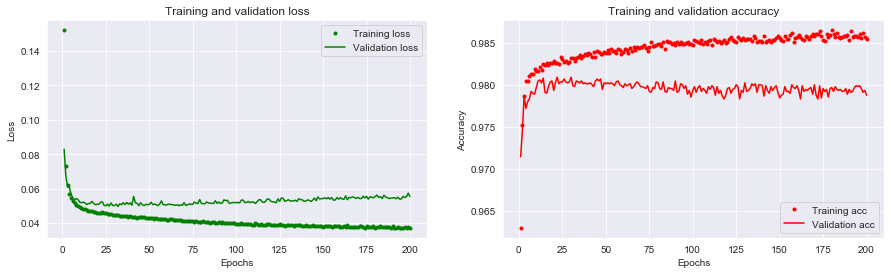

In [27]:
get_history_graph(history_1)

The charts above visualize the loss and accuracy of the model as a function of its training epochs.  Both the training and validation show slight amounts of noise, indicating that one hidden layer is probably insufficient for identifying the features within the data. Additionally, as the number of epochs increases, the model becomes less accurate on the validation set, indicating a degree of overfitting.  The ideal amount of epochs of training for this model is ~10.

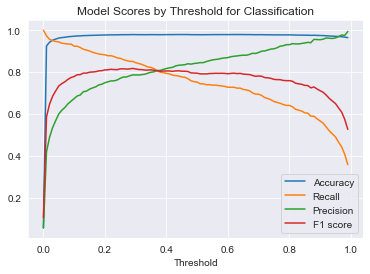

In [28]:
get_score_graph(model_1, X_test, y_test)

### Model 2

In [29]:
model_2 = Sequential()

model_2.add(Input(18,))
model_2.add(Dense(64))
model_2.add(Activation('relu'))

model_2.add(Dense(64))
model_2.add(Activation('relu'))

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

custom_compile(model_2)
history_2 = custom_fit(model_2, X_train, y_train, X_test, y_test)

Epoch 1/200
647/647 [==============================] - 1s 1ms/step - loss: 0.0904 - acc: 0.9734 - precision_5: 0.8699 - recall_5: 0.5770 - val_loss: 0.0609 - val_acc: 0.9768 - val_precision_5: 0.8248 - val_recall_5: 0.7293
Epoch 2/200
647/647 [==============================] - 1s 827us/step - loss: 0.0555 - acc: 0.9799 - precision_5: 0.8506 - recall_5: 0.7449 - val_loss: 0.0572 - val_acc: 0.9762 - val_precision_5: 0.7862 - val_recall_5: 0.7748
Epoch 3/200
647/647 [==============================] - 1s 890us/step - loss: 0.0548 - acc: 0.9801 - precision_5: 0.8278 - recall_5: 0.7801 - val_loss: 0.0570 - val_acc: 0.9790 - val_precision_5: 0.8860 - val_recall_5: 0.7066
Epoch 4/200
647/647 [==============================] - 1s 862us/step - loss: 0.0515 - acc: 0.9809 - precision_5: 0.8420 - recall_5: 0.7811 - val_loss: 0.0557 - val_acc: 0.9786 - val_precision_5: 0.8621 - val_recall_5: 0.7231
Epoch 5/200
647/647 [==============================] - 1s 862us/step - loss: 0.0506 - acc: 0.9816 - pr

In [30]:
score = model_2.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.22026927769184113
Test accuracy: 0.9767546653747559
Test precision: 0.7970085740089417
Test recall: 0.7706611752510071


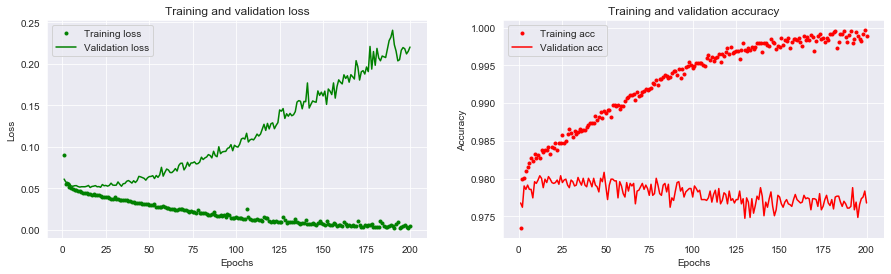

In [31]:
get_history_graph(history_2)

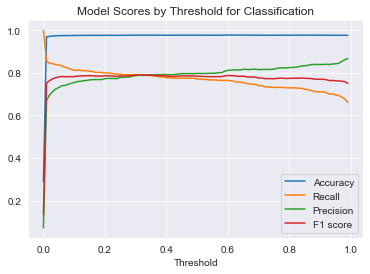

In [32]:
get_score_graph(model_2, X_test, y_test)

For this iteration, the optimal threshold for classification would be between 4 and 5, where it peaks just before it falls off.

### Model 3

In [33]:
model_3 = Sequential()

model_3.add(Input(18,))
model_3.add(Dense(64))
model_3.add(Dropout(0.2))
model_3.add(Activation('relu'))

model_3.add(Dense(64))
model_3.add(Dropout(0.2))
model_3.add(Activation('relu'))

model_3.add(Dense(1))
model_3.add(Activation('sigmoid'))

custom_compile(model_3)
history_3 = custom_fit(model_3, X_train, y_train, X_test, y_test)

Epoch 1/200
647/647 [==============================] - 1s 1ms/step - loss: 0.1112 - acc: 0.9666 - precision_6: 0.7948 - recall_6: 0.4852 - val_loss: 0.0667 - val_acc: 0.9757 - val_precision_6: 0.8257 - val_recall_6: 0.7045
Epoch 2/200
647/647 [==============================] - 1s 919us/step - loss: 0.0667 - acc: 0.9766 - precision_6: 0.8375 - recall_6: 0.6837 - val_loss: 0.0619 - val_acc: 0.9773 - val_precision_6: 0.8529 - val_recall_6: 0.7066
Epoch 3/200
647/647 [==============================] - 1s 917us/step - loss: 0.0610 - acc: 0.9789 - precision_6: 0.8267 - recall_6: 0.7523 - val_loss: 0.0569 - val_acc: 0.9780 - val_precision_6: 0.8449 - val_recall_6: 0.7314
Epoch 4/200
647/647 [==============================] - 1s 887us/step - loss: 0.0572 - acc: 0.9800 - precision_6: 0.8327 - recall_6: 0.7709 - val_loss: 0.0554 - val_acc: 0.9778 - val_precision_6: 0.8239 - val_recall_6: 0.7541
Epoch 5/200
647/647 [==============================] - 1s 910us/step - loss: 0.0562 - acc: 0.9803 - pr

In [34]:
score = model_3.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.06537448614835739
Test accuracy: 0.978672981262207
Test precision: 0.8641975522041321
Test recall: 0.7231404781341553


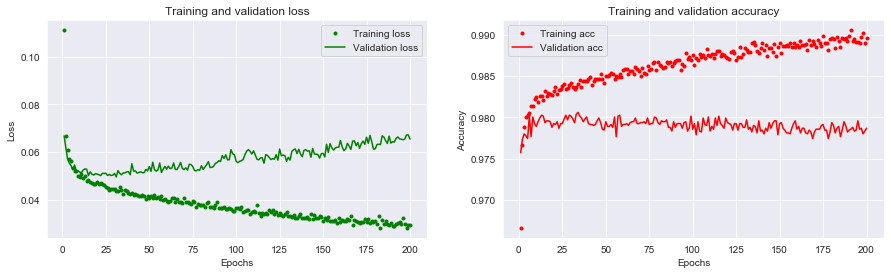

In [35]:
get_history_graph(history_3)

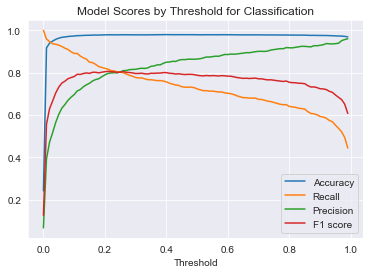

In [36]:
get_score_graph(model_3, X_test, y_test)

In [21]:
from sklearn.metrics import confusion_matrix
y_pred = model_3.predict(X_test)
y_pred = [1 if x > 0.6 else 0 for x in y_pred]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(8327, 51, 139, 345)

### Model 4

In [94]:
model_4 = Sequential()

model_4.add(Input(18,))
model_4.add(Dense(32))
model_4.add(Dense(32))
model_4.add(Activation('relu'))

model_4.add(Dense(64))
model_4.add(Dense(64))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.2))

model_4.add(Dense(128))
model_4.add(Dense(128))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.2))

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

custom_compile(model_4)
history_4 = custom_fit(model_4, X_train, y_train, X_test, y_test)

Epoch 1/100
647/647 [==============================] - 1s 2ms/step - loss: 0.0869 - acc: 0.9713 - precision_16: 0.7566 - recall_16: 0.6633 - val_loss: 0.0594 - val_acc: 0.9786 - val_precision_16: 0.8356 - val_recall_16: 0.7562
Epoch 2/100
647/647 [==============================] - 1s 2ms/step - loss: 0.0606 - acc: 0.9788 - precision_16: 0.8279 - recall_16: 0.7495 - val_loss: 0.0645 - val_acc: 0.9747 - val_precision_16: 0.7968 - val_recall_16: 0.7211
Epoch 3/100
647/647 [==============================] - 1s 2ms/step - loss: 0.0626 - acc: 0.9785 - precision_16: 0.8084 - recall_16: 0.7709 - val_loss: 0.0675 - val_acc: 0.9719 - val_precision_16: 0.6981 - val_recall_16: 0.8554
Epoch 4/100
647/647 [==============================] - 1s 1ms/step - loss: 0.0583 - acc: 0.9792 - precision_16: 0.8234 - recall_16: 0.7653 - val_loss: 0.0540 - val_acc: 0.9772 - val_precision_16: 0.8325 - val_recall_16: 0.7293
Epoch 5/100
647/647 [==============================] - 1s 1ms/step - loss: 0.0550 - acc: 0.9

In [95]:
score = model_4.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.07742186635732651
Test accuracy: 0.9794628620147705
Test precision: 0.8737623691558838
Test recall: 0.7293388247489929


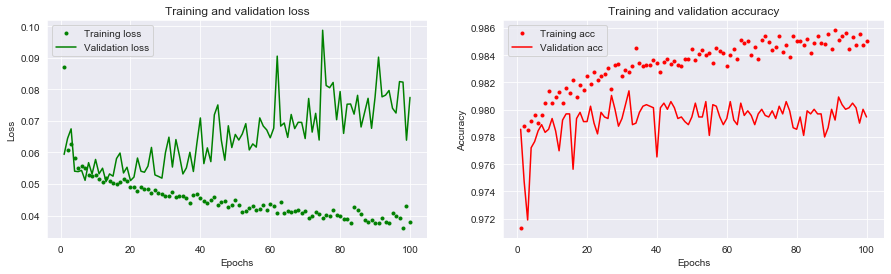

In [96]:
get_history_graph(history_4)

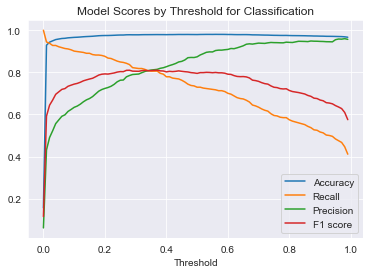

In [97]:
get_score_graph(model_4, X_test, y_test)

In [93]:
y_pred = model_4.predict(X_test)
y_pred = [1 if x > 0.8 else 0 for x in y_pred]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(8308, 70, 141, 343)

In [99]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,57.234213,0.894317,8.982633,57.819630,43.501664,5.744380,17.496295,3.098908,77.444268,32.576818,47.362625,7.955869,28.128325,94.415911,63.597291,2.567443,6.296718,0.487345
1,7.012085,-0.159496,0.196252,5.354920,6.783553,1.199241,0.051875,-0.795369,1.808591,4.956150,18.469706,4.919362,44.044704,0.653799,3.045179,0.075492,-0.407150,0.487345
2,13.871610,-0.648886,1.376535,41.865703,17.521159,2.265910,-0.193055,0.317281,24.237369,44.318834,24.585757,25.398135,34.137300,13.805521,40.719444,1.698158,-0.407150,0.487345
3,9.523445,-0.548096,4.463370,25.778671,44.334441,3.493050,3.154315,1.986257,27.730021,9.017379,11.290775,2.942101,9.013394,22.160700,12.556234,2.451539,1.357026,0.487345
4,0.961618,-1.485440,-0.191246,20.643327,3.645862,-0.282766,-0.165840,0.317281,13.565946,37.198217,13.621148,15.064593,13.351391,1.239311,4.498859,1.640206,1.004191,-2.051936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29533,-0.056031,1.931331,-0.548580,-0.089969,-0.097325,-0.764183,-0.601270,-1.351695,-0.076789,-0.117694,-0.088372,-0.047329,-0.077226,-0.046129,-0.078271,-1.199459,-0.759985,-2.051936
29534,-0.055453,0.674819,-0.500626,-0.089969,-0.096738,-0.646189,-0.220269,-0.795369,-0.074464,-0.128466,-0.070092,-0.094407,-0.047610,-0.046001,-0.077411,-1.141507,-0.407150,0.487345
29535,-0.039780,-0.355476,0.770151,-0.068301,-0.060913,1.350274,0.841092,0.317281,-0.058652,0.022348,-0.064196,0.023287,-0.061639,-0.037735,0.063370,0.307302,1.004191,0.487345
29536,-0.055643,0.540433,-0.258536,-0.086873,-0.093018,-0.334684,-0.492413,0.317281,-0.068418,-0.128466,-0.089257,-0.094407,-0.108401,-0.045204,-0.075479,1.118635,-0.407150,0.487345


In [100]:
df = pd.DataFrame(X)
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
12,-0.041530,0.336614,-0.383835,0.448639,0.121147,-0.443239,-0.410770,-0.239044,0.170626,2.090667,0.215308,1.459155,0.407545,-0.030062,0.159804,-0.967650,-0.759985,0.487345
17,0.839287,0.908875,2.358815,1.361795,0.857608,2.435821,0.378447,1.429932,1.135640,1.433545,1.576855,0.470525,1.350587,0.684503,1.332813,0.944777,0.298521,0.487345
21,-0.046374,0.643463,-0.309584,0.553884,0.641289,-0.145893,-0.247483,-0.795369,0.149698,0.571745,0.010692,0.446986,0.075531,-0.018669,0.031246,-0.388127,-0.759985,0.487345
25,0.017653,0.675939,-0.065174,1.315364,0.335703,0.019299,-0.437984,0.317281,0.708243,0.593290,0.340023,0.399908,0.597712,0.072438,0.139298,1.929967,-0.054314,0.487345
37,0.201199,0.992867,0.099571,2.312097,0.449050,0.760303,-0.301912,-0.239044,0.854739,1.724402,0.640459,1.388539,1.299149,0.223732,1.012547,-0.330174,-0.759985,0.487345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29533,-0.056031,1.931331,-0.548580,-0.089969,-0.097325,-0.764183,-0.601270,-1.351695,-0.076789,-0.117694,-0.088372,-0.047329,-0.077226,-0.046129,-0.078271,-1.199459,-0.759985,-2.051936
29534,-0.055453,0.674819,-0.500626,-0.089969,-0.096738,-0.646189,-0.220269,-0.795369,-0.074464,-0.128466,-0.070092,-0.094407,-0.047610,-0.046001,-0.077411,-1.141507,-0.407150,0.487345
29535,-0.039780,-0.355476,0.770151,-0.068301,-0.060913,1.350274,0.841092,0.317281,-0.058652,0.022348,-0.064196,0.023287,-0.061639,-0.037735,0.063370,0.307302,1.004191,0.487345
29536,-0.055643,0.540433,-0.258536,-0.086873,-0.093018,-0.334684,-0.492413,0.317281,-0.068418,-0.128466,-0.089257,-0.094407,-0.108401,-0.045204,-0.075479,1.118635,-0.407150,0.487345


In [101]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,57.234213,0.894317,8.982633,57.819630,43.501664,5.744380,17.496295,3.098908,77.444268,32.576818,47.362625,7.955869,28.128325,94.415911,63.597291,2.567443,6.296718,0.487345
1,7.012085,-0.159496,0.196252,5.354920,6.783553,1.199241,0.051875,-0.795369,1.808591,4.956150,18.469706,4.919362,44.044704,0.653799,3.045179,0.075492,-0.407150,0.487345
2,13.871610,-0.648886,1.376535,41.865703,17.521159,2.265910,-0.193055,0.317281,24.237369,44.318834,24.585757,25.398135,34.137300,13.805521,40.719444,1.698158,-0.407150,0.487345
3,9.523445,-0.548096,4.463370,25.778671,44.334441,3.493050,3.154315,1.986257,27.730021,9.017379,11.290775,2.942101,9.013394,22.160700,12.556234,2.451539,1.357026,0.487345
4,0.961618,-1.485440,-0.191246,20.643327,3.645862,-0.282766,-0.165840,0.317281,13.565946,37.198217,13.621148,15.064593,13.351391,1.239311,4.498859,1.640206,1.004191,-2.051936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29533,-0.056031,1.931331,-0.548580,-0.089969,-0.097325,-0.764183,-0.601270,-1.351695,-0.076789,-0.117694,-0.088372,-0.047329,-0.077226,-0.046129,-0.078271,-1.199459,-0.759985,-2.051936
29534,-0.055453,0.674819,-0.500626,-0.089969,-0.096738,-0.646189,-0.220269,-0.795369,-0.074464,-0.128466,-0.070092,-0.094407,-0.047610,-0.046001,-0.077411,-1.141507,-0.407150,0.487345
29535,-0.039780,-0.355476,0.770151,-0.068301,-0.060913,1.350274,0.841092,0.317281,-0.058652,0.022348,-0.064196,0.023287,-0.061639,-0.037735,0.063370,0.307302,1.004191,0.487345
29536,-0.055643,0.540433,-0.258536,-0.086873,-0.093018,-0.334684,-0.492413,0.317281,-0.068418,-0.128466,-0.089257,-0.094407,-0.108401,-0.045204,-0.075479,1.118635,-0.407150,0.487345
